In [1]:
# -*- coding: utf-8 -*-

"""
This software is part of GPU Ocean. 
Copyright (C) 2019 SINTEF Digital

This python program is used to set up and run a data-assimilation 
and drift trajectory forecasting experiment.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""


import sys, os, json, datetime, time, shutil
import numpy as np

current_dir = os.getcwd()

if os.path.isdir(os.path.abspath(os.path.join(current_dir, '../../SWESimulators'))):
        sys.path.insert(0, os.path.abspath(os.path.join(current_dir, '../../')))

# LETKF for observation with all moorings

## Set up ensemble from file 
1. Parameters
2. Input files
3. UDF packages + UDF plotting functions
4. ensemble initialization


In [2]:
#--------------------------------------------------------------
# PARAMETERS
#--------------------------------------------------------------
args_ensemble_size = 100
args_method = "ETKF" 
args_observation_interval = 1
args_observation_variance = 1.0
args_observation_type = "buoys"
args_buoy_area = "all"
args_media_dir = "forecasting_results/"

args_num_days = 7
args_num_hours = 24
args_forecast_days = 3
args_profiling = False


# Checking input args
if args_ensemble_size is None:
    print("Ensemble size missing, please provide a --ensemble_size argument.")
    sys.exit(-1)
elif args_ensemble_size < 1:
    print("Illegal ensemble size " + str(args_ensemble_size))

profiling = args_profiling


In [3]:
###-----------------------------------------
## Define files for ensemble and truth.
##

#INPUT
#ensemble_init_path = 'C:/Users/florianb/Documents/GPU-Ocean/gpu-ocean/data/ensemble_init/'
#ensemble_init_path = '/lustre/storeB/users/florianb/data/ensemble_init/'
ensemble_init_path = '/sintef/data/ensemble_init/'

assert len(os.listdir(ensemble_init_path)) == 100 or len(os.listdir(ensemble_init_path)) == 101, \
    "Ensemble init folder has wrong number of files: " + str(len(os.listdir(ensemble_init_path)))

#INPUT
#truth_path = 'C:/Users/florianb/Documents/GPU-Ocean/gpu-ocean/data/true_state/'
#truth_path = '/lustre/storeB/users/florianb/data/true_state/'
truth_path = '/sintef/data/true_state/'
assert len(os.listdir(truth_path)) == 2 or len(os.listdir(truth_path)) == 3, \
    "Truth folder has wrong number of files"    
    
# Reading and checking method
method = str(args_method).lower()
if method == 'iewpf2':
    print(' ----> Using IEWPF 2 stage method')
elif method == 'enkf':
    print(' ----> Using EnKF')
elif method == 'etkf':
    print(' ----> Using ETKF')
elif method == 'none':
    print(' ----> No data assimilation')
else:
    print('Illegal method: ' + str(method))
    sys.exit(-1)
    

# Time parameters
start_time      =  3*24*60*60 #  3 days in seconds
simulation_time = 10*24*60*60 # 10 days in seconds (three days spin up is prior to this)fa
end_time        = 13*24*60*60 # 13 days in seconds


# Based on truth from June 25th 2019
#drifterSet = [ 2, 7, 12, 24, 29, 35, 41, 48, 53, 60]
drifterSet = [ 2, 24, 60]

# Log extra information for the ensemble state for the following cells:
extraCells = np.array([[254, 241], # Cross with two trajectories
                       [249, 246], # northwest of above
                       [259, 236], # southeast of above
                       [343, 131], # Closed circle of same drifter
                       [196,  245], # Middle of single trajectory
                       [150,  250], # Middle of single trajectory, later than above
                       [102, 252], # On the same trajectory as the above, but later, and also in a intersection
                       [ 388, 100], # Unobserved area just north of southern jet
                       [ 388, 80],  # Unobserved area in southern jet
                       [ 388, 150], # Unobserved area in calm area
                      ])

 ----> Using ETKF


In [4]:
###--------------------------------
# Import required packages
#
tic = time.time()
# For GPU contex:
from SWESimulators import Common
# For the ensemble:
from SWESimulators import EnsembleFromFiles, Observation
# For data assimilation:
from SWESimulators import IEWPFOcean
import ETKFOcean
# For forcasting:
from SWESimulators import GPUDrifterCollection
# For ObservationType:
from SWESimulators import DataAssimilationUtils as dautils

toc = time.time()
print("\n{:02.4f} s: ".format(toc-tic) + 'GPU Ocean packages imported', True)

# Create CUDA context
tic = time.time()
gpu_ctx = Common.CUDAContext()
device_name = gpu_ctx.cuda_device.name()
toc = time.time()
print("{:02.4f} s: ".format(toc-tic) + "Created context on " + device_name, True)


0.4855 s: GPU Ocean packages imported True
0.0930 s: Created context on NVIDIA GeForce RTX 3090 True


In [5]:
from matplotlib import pyplot as plt 
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

def imshow(im, interpolation="None", title=None, figsize=(4,4), interior=False):
    fig = plt.figure(figsize=figsize)
    
    if interior:
        im = plt.imshow(im[2:-2,2:-2], interpolation=interpolation, origin='lower')
    else:
        im = plt.imshow(im, interpolation=interpolation, origin='lower')
    
    plt.colorbar()
    if title is not None:
        plt.title(title)
        
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(12.5,3.4), # (12.5, 3.4)
            color_bar_from_zero=False, save_filename=None, constant_range=False, pretitle='',
            mark_drifter_positions = None):
    
    fig, axs = plt.subplots(1,3, figsize=figsize)
    
    #fig = plt.figure(figsize=figsize)

    #gs = fig.add_gridspec(1,10)#, sharey=True)
    #axs = [None, None, None]
    #axs[0] = fig.add_subplot(gs[0, 1:4])
    #axs[1] = fig.add_subplot(gs[0, 4:7])
    #axs[2] = fig.add_subplot(gs[0, 7:10])
    
    eta_max = np.max(np.abs(eta))
    huv_max = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    
    if constant_range:
        eta_max = 3.5
        huv_max = 625
    
    eta_cmap = 'BrBG'
    huv_cmap = 'RdBu'
    
    eta_min = -eta_max
    huv_min = -huv_max
    if color_bar_from_zero:
        eta_min, huv_min = 0, 0
        if constant_range:
            eta_max = 0.12
            huv_max = 50
        
        eta_cmap = 'BuGn'
        huv_cmap = 'Blues'
        
    nx = ensemble.nx
    ny = ensemble.ny
    dx = ensemble.dx
    dy = ensemble.dy
    extent=np.array([0, nx*dx, 0, ny*dy]) / 1000
    
    
    fontsize = 18
    def addColorbar(ax, im, title):
        ax_divider = make_axes_locatable(ax)
        ax_cb = ax_divider.append_axes("top", size="10%", pad="5%")
        cbar = colorbar(im, cax=ax_cb, orientation="horizontal")
        ax_cb.xaxis.set_ticks_position("top")
        ax_cb.set_title(title, fontsize=fontsize)
    
    eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', 
                           vmin=eta_min, vmax=eta_max, extent=extent, cmap=eta_cmap) #GnBu')
    addColorbar(axs[0], eta_im, pretitle+"$\eta$ [m]")
    
    hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', 
                          vmin=huv_min, vmax=huv_max, extent=extent, cmap=huv_cmap)
    addColorbar(axs[1], hu_im, pretitle+"$hu$ [m$^2$/s]")
    
    
    hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower',
                          vmin=huv_min, vmax=huv_max, extent=extent, cmap=huv_cmap)
    addColorbar(axs[2], hv_im, pretitle+"$hv$ [m$^2$/s]")
    
    
    if title is not None:
        plt.suptitle(r"\textbf{"+title+"}", y=1.1) #, fontsize=14)
    #plt.tight_layout()
    

/home/florianb/miniconda3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
###--------------------------
# Initiate the ensemble
#

observation_type = dautils.ObservationType.UnderlyingFlow
if args_observation_type == 'buoys':
    observation_type = dautils.ObservationType.StaticBuoys
    print('Observation type changed to StaticBuoys!')
elif args_observation_type == 'all_drifters':
    drifterSet = 'all'
    print('Using all drifters for DA experiment')

print(observation_type)

cont_write_netcdf = False

tic = time.time()
ensemble = EnsembleFromFiles.EnsembleFromFiles(gpu_ctx, args_ensemble_size, \
                                               ensemble_init_path, truth_path, \
                                               args_observation_variance,
                                               cont_write_netcdf = cont_write_netcdf,
                                               use_lcg = True,
                                               observation_type=observation_type)

# Configure observations according to the selected drifters:
ensemble.configureObservations(drifterSet=drifterSet, 
                               observationInterval = args_observation_interval,
                               buoy_area = args_buoy_area)
ensemble.configureParticleInfos(extraCells)
toc = time.time()
print("{:02.4f} s: ".format(toc-tic) + "Ensemble is loaded and created", True)
print("Using drifterSet:\n" + str(drifterSet))
if args_observation_type == 'buoys':
    print('buoys to read:')
    print(str(ensemble.observations.read_buoy))


dt_ref = ensemble.particles[-1].dt

Observation type changed to StaticBuoys!
4


## Data Assimilaion Initialisation 


In [ ]:
### -------------------------------
# Initialize DA class (if needed)
#
tic = time.time()
iewpf = None
if method.startswith('iewpf'):
    iewpf = IEWPFOcean.IEWPFOcean(ensemble)
    toc = time.time()
    print("{:02.4f} s: ".format(toc-tic) + "Data assimilation class IEWPFOcean initiated", True)
elif method.startswith('enkf'):
    enkf = EnKFOcean.EnKFOcean(ensemble)
    toc = time.time()
    print("{:02.4f} s: ".format(toc-tic) + "Data assimilation class EnKFOcean initiated", True)
elif method.startswith('etkf'):
    etkf = ETKFOcean.ETKFOcean(ensemble, inflation_factor=1.0)
    toc = time.time()
    print("{:02.4f} s: ".format(toc-tic) + "Data assimilation class ETKFOcean initiated", True)
else:
    toc = time.time()
    print("{:02.4f} s: ".format(toc-tic) + "Skipping creation of a DA class", True)


0.0009 s: Data assimilation class ETKFOcean initiated True


In [ ]:
### ----------------------------------------------
#   DATA ASSIMILATION
#

obstime = start_time # time in seconds (starting after spin-up phase)

master_tic = time.time()

numDays = args_num_days 
numHours = args_num_hours 
forecast_days = args_forecast_days

dt_ref = ensemble.particles[-1].dt

print('---------- Starting simulation --------------') 
print('--- numDays:       ' + str(numDays))
print('--- numHours:      ' + str(numHours))
print('--- forecast_days: ' + str(forecast_days))
print('---------------------------------------------') 

for hour in range(1):
    for fiveMin in range(1):
        for minute in range(5):
            print("Time = ", 60*hour+5*fiveMin+minute)
            obstime += 60
            ensemble.stepToObservation(obstime)
            if minute == 4:
                etkf.LETKF(ensemble)

        ensemble.deactivateDegeneratedParticles(0.5*dt_ref, 1.5*dt_ref)

---------- Starting simulation --------------
--- numDays:       7
--- numHours:      24
--- forecast_days: 3
---------------------------------------------
Time =  0
Time =  1
Time =  2
Time =  3
Time =  4


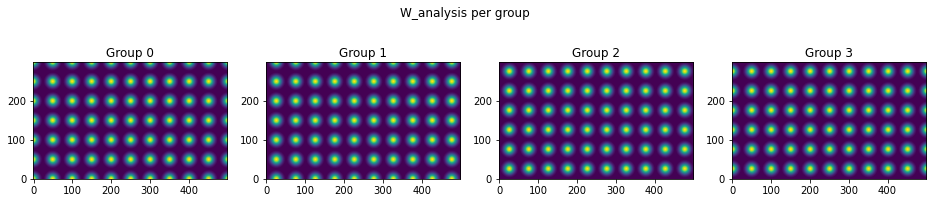

In [ ]:
fig, axs = plt.subplots(1,len(etkf.groups), figsize=(16,8))
fig.suptitle("W_analysis per group", y=0.7)
for g in range(len(etkf.groups)):
    axs[g].imshow(etkf.W_analyses[g], origin="lower")
    axs[g].set_title("Group " + str(g))
    


In [ ]:
ensemble.getNumActiveParticles()

100

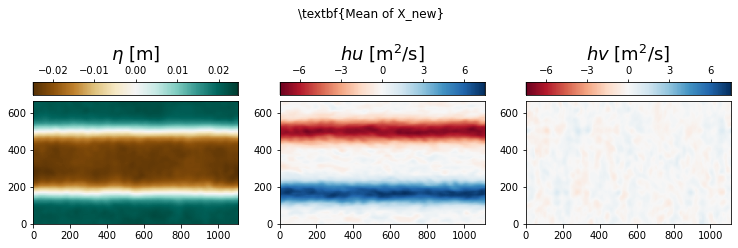

In [ ]:
X = np.zeros((100,3,ensemble.ny,ensemble.nx))

idx = 0
for e in range(100):
    if ensemble.particlesActive[e]:
        eta, hu, hv = ensemble.particles[e].download(interior_domain_only=True)
        X[idx,0,:,:] = eta 
        X[idx,1,:,:] = hu
        X[idx,2,:,:] = hv


In [ ]:
X_mean = np.nanmean(X, axis=0 )

imshow3(X_mean[0], X_mean[1], X_mean[2], title="Mean of X_new")

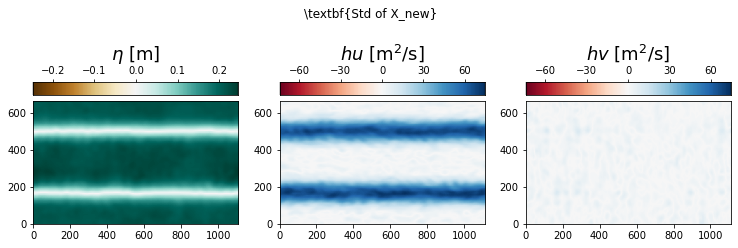

In [ ]:
X_std = np.std(X[:,:,:,:], axis=0)

imshow3(X_std[0], X_std[1], X_std[2], title="Std of X_new")